# Dimensionality reduction on trial features

In [4]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode

from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.metrics import dtw_path

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files

from one.api import ONE
one = ONE(mode='remote')

## Parameters

In [5]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/')

# LOAD DATA
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [6]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per trial epoch

In [7]:
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'epoch_sequences_10_03-11-2025')
all_sequences = pickle.load(open(filename, 'rb'))

In [8]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [9]:
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')

## Get timing data

In [10]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial01-09-2025')
old_trial_data = pd.read_parquet(filename, engine='pyarrow')
old_trial_data['trial_id'] = old_trial_data['sample'].str.split().str[1:2].str.join('')
# old_trial_data = pd.DataFrame(old_trial_data.groupby(['session', 'trial_id'])['ballistic'].mean()).reset_index()

In [11]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type02-28-2025')
filename_states = str(results_path + 'states_trial_type03-11-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

In [12]:
# Get timing info
vars = ['trial_id', 'session', 'mouse_name']

elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)
ballistic = pd.DataFrame(old_trial_data.groupby(vars)['ballistic'].mean()).reset_index()
ballistic['trial_id'] = ballistic['trial_id'].astype(str)

In [13]:
# Merge

merged_df = df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(ballistic, on=['session', 'trial_id', 'mouse_name'])

merged_df['contrast'] = merged_df['contrast'].astype(float)
merged_df['block'] = merged_df['block'].astype(float)

# Timing quantiles and choice
merged_df['response_qt'] = pd.qcut(merged_df['response'], 4, labels=False)/4
merged_df['elongation_qt'] = pd.qcut(merged_df['elongation'], 4, labels=False)/4

merged_df['choice'] = merged_df['trial_type'].str.split().str[3:4].str.join('')
merged_df.loc[merged_df['choice']=='left', 'choice'] = 0
merged_df.loc[merged_df['choice']=='right', 'choice'] = 1

merged_df.loc[merged_df['feedback']=='correct', 'feedback'] = 1
merged_df.loc[merged_df['feedback']=='incorrect', 'feedback'] = 0



In [14]:
del states_file

## Separate states per variable

#### Use one epoch

In [7]:
epoch_to_analyse = ['Quiescence']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr
    # print('{0}'.format(encoded_arr))

#### Use all epochs

In [15]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(merged_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr
    # print('{0}'.format(encoded_arr))

### Add timing and choice info

In [12]:
new_columns = np.array(merged_df[['response_qt', 'response_qt', 'choice']]).astype(float)
new_columns = np.array(merged_df[['response_qt', 'response_qt']]).astype(float)

final_matrix = np.concatenate((binarized, new_columns), axis=1)

In [16]:
final_matrix = binarized.copy()

([<matplotlib.axis.XTick at 0x7b97e4ee1820>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480')])

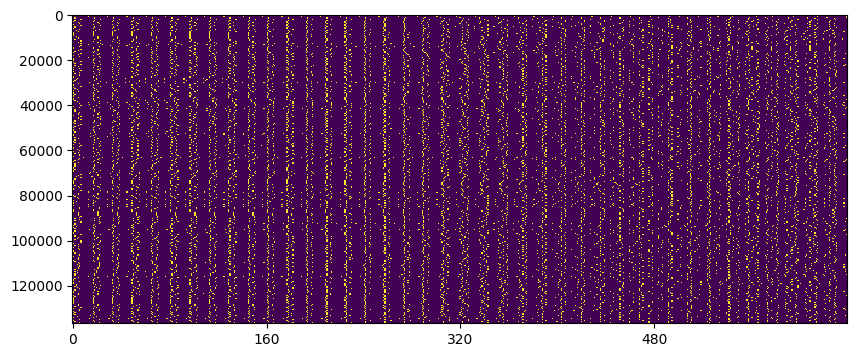

In [15]:
plt.figure(figsize=(10, 4))
plt.imshow(final_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

In [41]:
color = sns.color_palette("Spectral", 10)
# fig, axs = plt.subplots(1, len(np.unique(y_kmeans_trials)), sharex=True, sharey=False, figsize=(18, 4))

sequences_choice = np.vstack(df[[epoch_to_analyse]].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
cluster_count = np.zeros((16, 10))

#     plt.figure(figsize=(6, 2))
for b, bin in enumerate(range(10)):
    counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
    cluster_count[:, b] = counts
    # plt.plot(bins[:-1], counts, color=color[b])
#         plt.stairs(counts, bins, color=color[b], alpha=1)
#         plt.xticks(np.arange(0, 16, 1), np.arange(0, 16, 1))
#         plt.title(cluster)
#     plt.show()
plt.imshow(cluster_count, cmap='Greys', aspect='auto')
plt.yticks(np.arange(0, 16, 1), ['000', '100', '200','300', '010', '110','210','310','001','101',
        '201', '301', '011', '111','211','311'
        ])
# axs[c].set_xticks(np.arange(0, 11, 5), np.arange(0, 1.1, .5))
# axs[c].set_xlabel('Time in epoch')
# axs[c].set_title(cluster)
# axs[0].set_ylabel('States')
# plt.tight_layout()
# plt.show()


KeyError: "None of [Index([('Pre-quiescence', 'Quiescence', 'Choice', 'ITI')], dtype='object', name='broader_label')] are in the [columns]"

## Prepare design matrix

In [17]:
ori_X = binarized.copy()
ori_X = final_matrix.copy()

print(np.shape(ori_X))

(136666, 640)


## Reduce dimensionality with PCA

In [18]:
n_components = 200
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
X_pca = pca.fit_transform(ori_X)


Text(0.5, 1.0, 'Explained Variance by PCA')

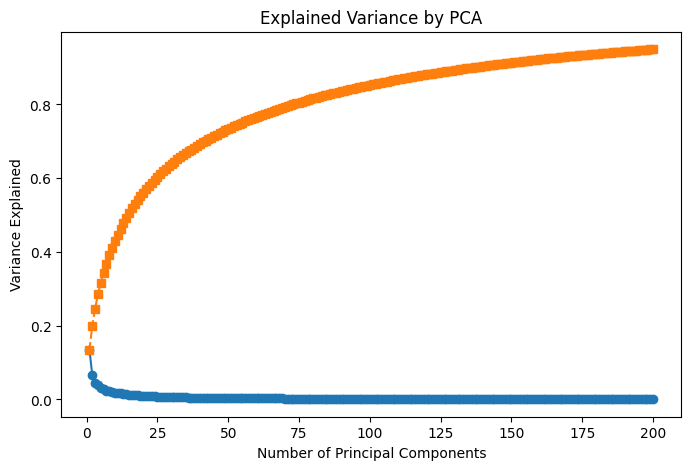

In [19]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")


## UMAP assessment

In [20]:
reducer = umap.UMAP(random_state= 42, n_components=2)
# reducer = umap.UMAP(n_components=2)

embedding = reducer.fit_transform(ori_X)
# embedding = reducer.fit_transform(X_pca)
embedding.shape

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(136666, 2)

/tmp/ipykernel_8067/1840640554.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


Text(0.5, 1.0, "['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']")

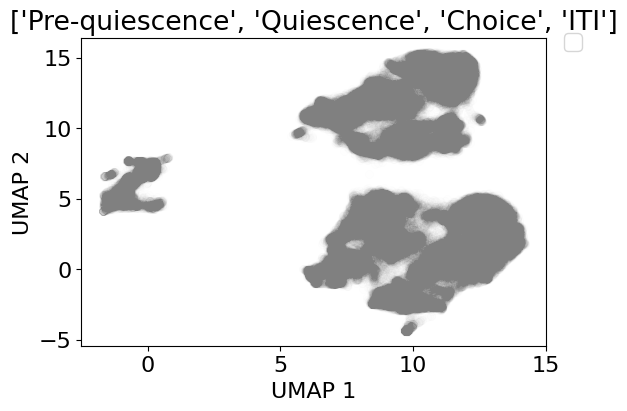

In [20]:
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 16})

scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.005,
    c='grey'  # Choose a colormap
)   
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title(epoch_to_analyse)

# Save the figure as an SVG file
# plt.savefig(file_path+'UMAP_grey', format="svg")

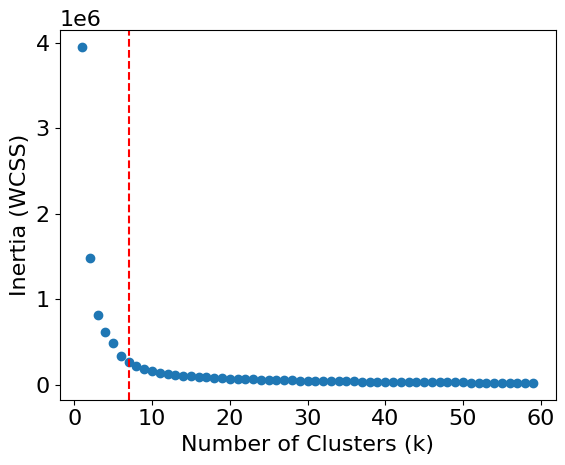

In [26]:
from kneed import KneeLocator
# Assuming `X` is your data
inertia_values = []
K = range(1, 60)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(embedding)[0]*0.8)
    X_train = np.vstack([embedding[:cutoff, 0], embedding[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)
    
kneedle = KneeLocator(K, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
# plt.title(epoch_to_analyse)
# Save the figure as an SVG file
save_path = '/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE/'
plt.savefig(save_path+'inertia_values_trial_clusters.svg', format="svg")
plt.show()



## Test GMM with different components

In [140]:
repeats = 1
components = np.array([1, 2, 3, 4, 5, 6, 7])
components = np.arange(1, 60, 2)
components = np.array([3, 6, 9])


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Text(0.5, 1.0, 'ITI')

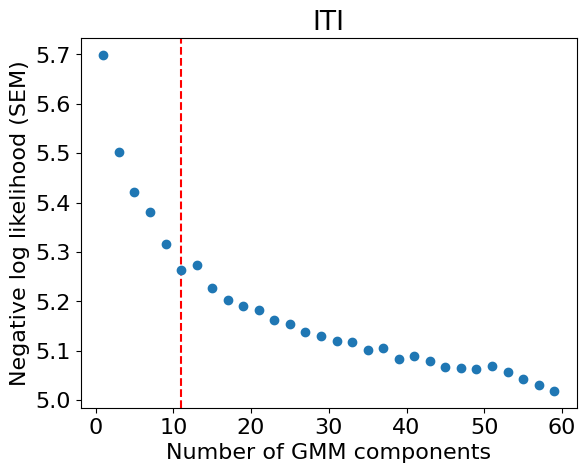

In [121]:
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    
    reducer = umap.UMAP(n_components=2)  # Allow for random seed on each iteration

    # Standardization using StandardScaler
    scaler = StandardScaler()
    standardized_X = scaler.fit_transform(ori_X)

    embeding = reducer.fit_transform(ori_X)
    embeding.shape
    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_neg_log_likelihood(embeding, components)


In [23]:

kneedle = KneeLocator(components, np.nanmean(LLs, axis=0), curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')

plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Negative log likelihood (SEM)')
plt.title(epoch_to_analyse)

NameError: name 'KneeLocator' is not defined

## Run UMAP with fixed random seed

### Test for different min_dist 

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


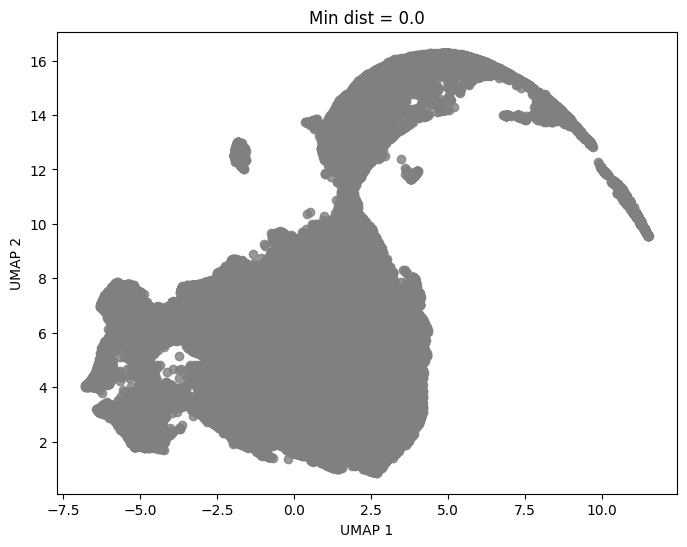

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


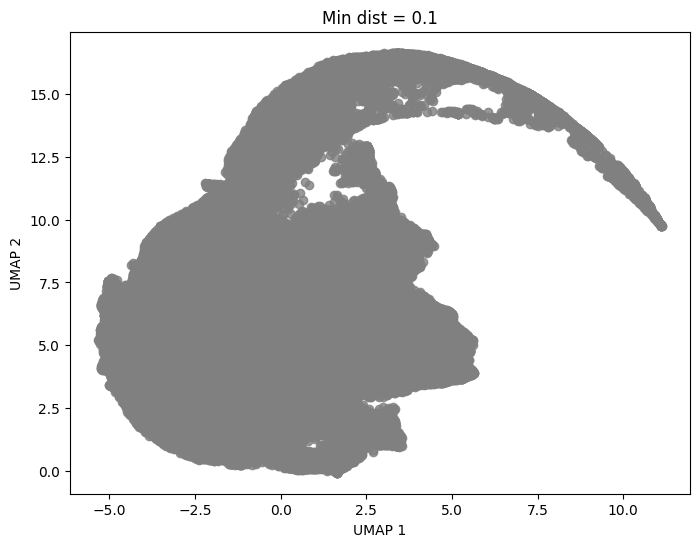

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [11]:
repeats = 3
components = np.array([2, 5, 6, 9])
min_dists = np.array([0.0, 0.1, 0.5, 0.99]) 
LL_min_dist = np.zeros((len(min_dists), len(components))) * np.nan

for d, min_dist in enumerate(min_dists):    
    LLs = np.zeros((repeats, len(components))) * np.nan
    
    for r in range(repeats):  
        
        reducer = umap.UMAP(n_components=2, min_dist=min_dist)  # Allow for random seed on each iteration

        # Standardization using StandardScaler
        scaler = StandardScaler()
        standardized_X = scaler.fit_transform(ori_X)

        mouse_embedding = reducer.fit_transform(ori_X)
        mouse_embedding.shape
        
        # Compute log likelihood of a GMM model with different components
        LLs[r, :] = GMM_neg_log_likelihood(mouse_embedding, components)
    
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        mouse_embedding[:, 0],
        mouse_embedding[:, 1],
        alpha=0.8,
        c='grey'  # Choose a colormap
    )  
    plt.title(str('Min dist = '+str(min_dist)))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    
    # Compute log likelihood of a GMM model with different components
    LL_min_dist[d, :] = np.mean(LLs, axis=0)
    
plt.imshow(LL_min_dist)
plt.yticks([0, 1, 2, 3, 4, 5], min_dists)
plt.xticks(np.arange(0, len(components), 1), components)
# plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(len(min_dists)), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('Minimum distance')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")

### Test for different n_neighbours

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


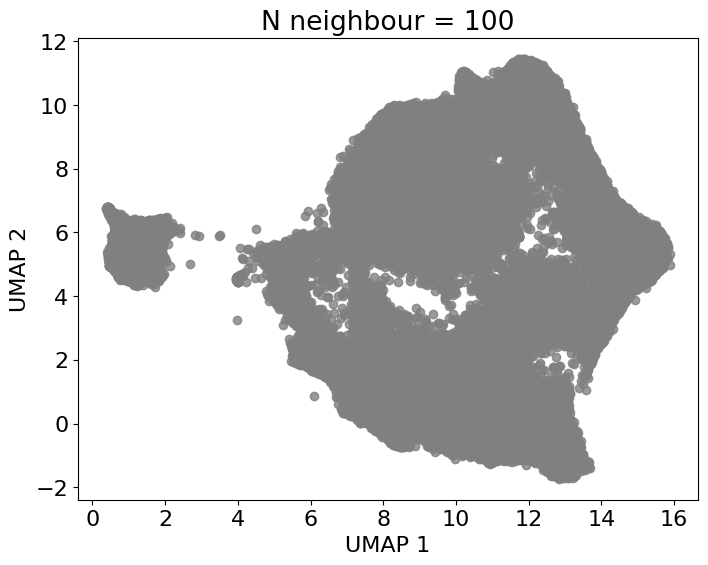

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


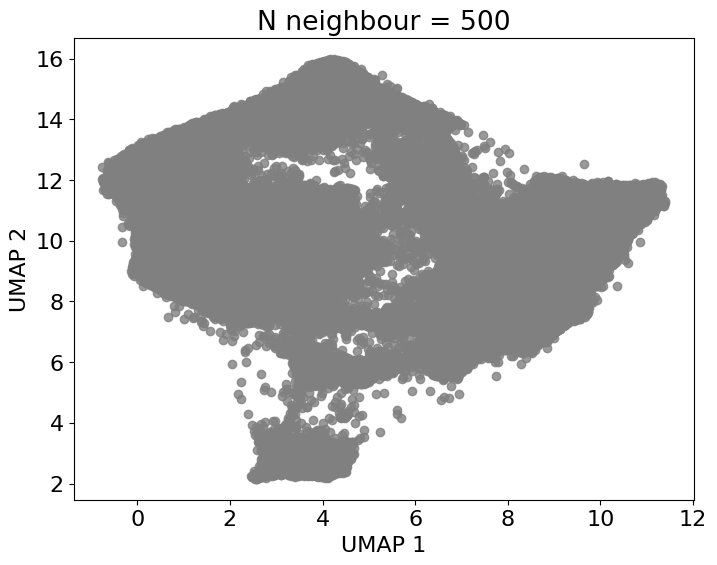

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


: 

In [142]:
repeats = 1
n_neighbours = np.array([100, 500, 1000]) 
LL_neighbours = np.zeros((len(n_neighbours), len(components))) * np.nan

for n, n_neighbour in enumerate(n_neighbours):    
    LLs = np.zeros((repeats, len(components))) * np.nan
    
    for r in range(repeats):  
        
        reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbour)  # Allow for random seed on each iteration

        # Standardization using StandardScaler
        scaler = StandardScaler()
        standardized_X = scaler.fit_transform(ori_X)

        mouse_embedding = reducer.fit_transform(ori_X)
        mouse_embedding.shape
        
        # Compute log likelihood of a GMM model with different components
        LLs[r, :] = GMM_neg_log_likelihood(mouse_embedding, components)
    
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        mouse_embedding[:, 0],
        mouse_embedding[:, 1],
        alpha=0.8,
        c='grey'  # Choose a colormap
    )  
    plt.title(str('N neighbour = '+str(n_neighbour)))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()
    
    # Compute log likelihood of a GMM model with different components
    LL_neighbours[n, :] = np.mean(LLs, axis=0)
    
plt.imshow(LL_neighbours)
plt.yticks([0, 1, 2, 3], n_neighbours)
plt.xticks(np.arange(0, len(components), 1), components)
# plt.errorbar(components, np.mean(LLs, axis=0), np.std(LLs, axis=0)/np.sqrt(len(min_dists)), linestyle='None', marker='o')
plt.xlabel('Number of GMM components')
plt.ylabel('N neighbors')
# plt.savefig(file_path+'NLL_mice.svg', format="svg")

## K-means clustering of data

In [25]:
optimal_k = 7

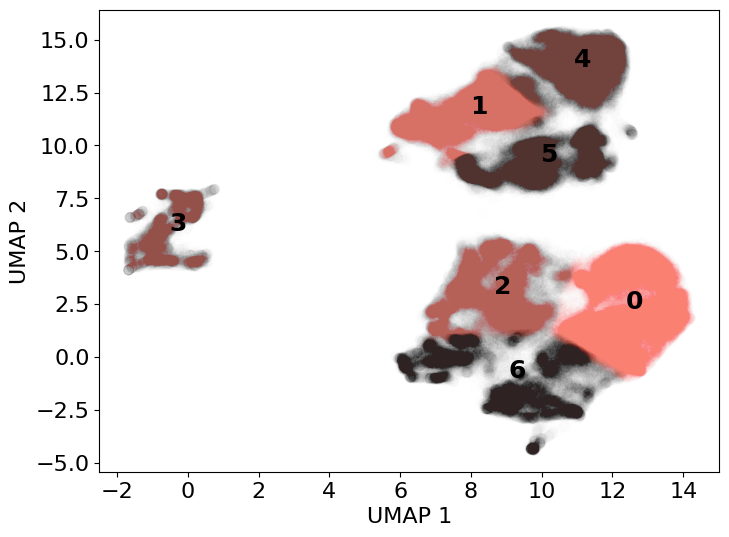

In [27]:
# Step 2: Perform KMeans Clustering
data_2d = embedding
# data_2d = X_pca
kmeans_trials = KMeans(n_clusters=optimal_k, random_state=2024)
kmeans_trials.fit(data_2d)

y_kmeans_trials = kmeans_trials.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))
# Plot each cluster with a different color
palette = sns.color_palette("Set2", 7)  # List of 6 colors
palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
# Map the cluster labels to colors
colors = [palette[i] for i in y_kmeans_trials]
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], s=50, alpha=0.005, c=colors) # sns.color_palette("Set2", as_cmap=True) , cmap='Set2' c=y_kmeans_trials, 



# Plot the centroids
centroids = kmeans_trials.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=1, fontsize=18, weight='bold')


# plt.title(epoch_to_analyse + " clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.title(epoch_to_analyse)

# Save the figure as an SVG file
save_path = '/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE/'
plt.savefig(save_path+'trial_clusters_umap.svg', format="svg")
plt.show()


In [28]:
column_name = 'Pre-qui_clusters'
column_name = 'cluster'
merged_df[column_name] = y_kmeans_trials

# Save for further mouse clustering

In [25]:
file_to_save = merged_df.copy()
filename = "cluster_per_trial_no_timing"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '2.4_trial_epoch_seq_clustering.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

## Vizualize results

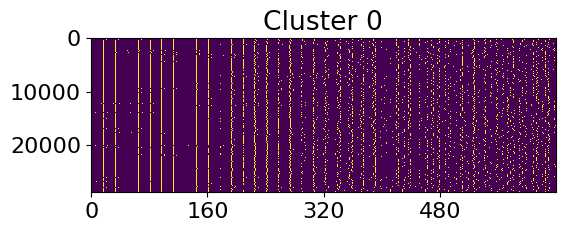

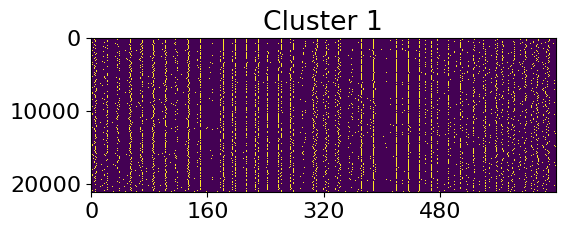

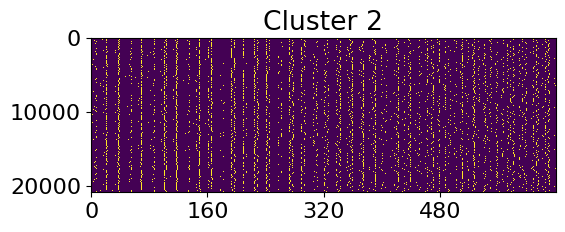

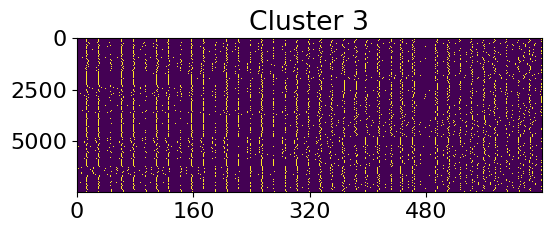

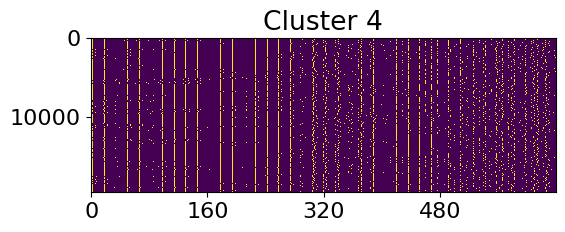

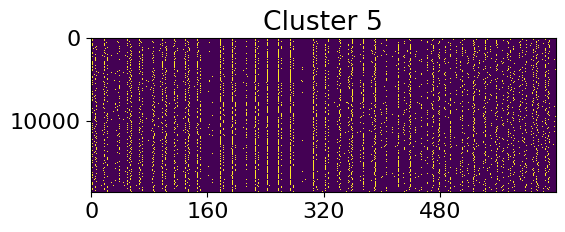

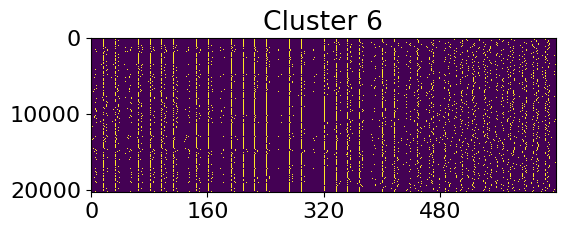

In [29]:
for c, cluster in enumerate(np.unique(y_kmeans_trials)):
    indices = np.where(y_kmeans_trials==c)[0]
    data = final_matrix[indices, :]
    plt.figure(figsize=(6, 2))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))
    plt.title('Cluster ' + str(c))
    plt.show()

In [33]:
use_key = 'feedback' # session trial_typefilter
use_order = ['correct', 'incorrect']
# use_order = ['0.0', '0.0625', '0.125', '0.25', '1.0']
# use_order = ['0.5', '0.2', '0.8']
unique_numeric_labels = np.arange(0, len(use_order), 1)
map_to_use = dict(zip(use_order, unique_numeric_labels))

# Apply map
unique_trial_types = merged_df[use_key].unique()
# trial_type_map = dict(zip(unique_trial_types, unique_numeric_labels))
merged_df['numeric_trial_code'] = merged_df[use_key].map(map_to_use)

In [34]:
plt.figure(figsize=(8, 6))

filter = merged_df[use_key].isin(use_order)
plt.rcParams.update({'font.size': 16})

# Plotting the scatter plot
scatter = plt.scatter(
    embedding[:, 0][filter],
    embedding[:, 1][filter],
    c=df.loc[filter, 'numeric_trial_code'],
    alpha=0.05,
    cmap='viridis'  # Choose a colormap
)  

# Create the custom legend
handles = []
for code, label in zip(unique_numeric_labels[0:], use_order[0:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

# x.legend(bbox_to_anchor=(1.1, 1.05))
plt.legend(handles=handles, title=use_key, bbox_to_anchor=(.76, .75))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.xlim([-15, 25])
# plt.gca().set_aspect('equal', 'datalim')

KeyError: 'numeric_trial_code'

<Figure size 800x600 with 0 Axes>